In [1]:
import numpy as np

import lunar_lander
from turbo_test import demo_heuristic_lander
import tensorflow as tf
import trieste

2021-11-02 09:58:05.763486: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-02 09:58:05.763505: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-11-02 09:58:07.046917: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-02 09:58:07.047279: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-02 09:58:07.047323: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.s

In [2]:
# this space is created by doing +-0.1 around parameter values
# set in https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py
# search_space = trieste.space.Box(
#     [0.4, 0.9, 0.3, 0.5, 0.4, 0.9, 0.4, 0.4, 0.0, 0.5, 0.0, 0.0],
#     [0.6, 1.1, 0.5, 0.6, 0.6, 1.1, 0.6, 0.6, 0.1, 0.6, 0.1, 0.1]
# )

search_space = trieste.space.Box([0.0], [1.5]) ** 12

In [26]:
OBJECTIVE = "OBJECTIVE"
# lander crashed
CRASH = "CRASH"
# didn't finish in predefined number of steps
TIMEOUT = "TIMEOUT"
# lander landed fine, but outside the helipad
OUTSIDE = "OUTSIDE"

create_empty_dataset = lambda : trieste.data.Dataset(tf.zeros((0, search_space.dimension), tf.float64), tf.zeros((0, 1), tf.float64))

def lander_observer(x):
    all_datasets = {
        OBJECTIVE: create_empty_dataset(),
        CRASH: create_empty_dataset(),
        TIMEOUT: create_empty_dataset(),
        OUTSIDE: create_empty_dataset()
    }

    def add_data(dataset_tag, x, y):
        new_dataset = trieste.data.Dataset(np.atleast_2d(x), np.atleast_2d(y))
        all_datasets[dataset_tag] += new_dataset

    for w in x.numpy():
        result = demo_heuristic_lander(lunar_lander.LunarLander(), w)
        if result.timeout:
            add_data(TIMEOUT, w, 0.0)
            continue
        else:
            add_data(TIMEOUT, w, 1.0)

        if result.has_crashed:
            add_data(CRASH, w, 0.0)
            continue
        else:
            add_data(CRASH, w, 1.0)

        if not result.is_in_helipad:
            add_data(OUTSIDE, w, 0.0)
            continue
        else:
            add_data(OUTSIDE, w, 1.0)

        # all failure modes are done, means we landed successfully
        normalized_fuel = np.float64(result.total_fuel / 100.0)
        add_data(OBJECTIVE, w, normalized_fuel)
    
    return all_datasets

In [31]:
num_initial_points = 1
initial_query_points = search_space.sample(1)
initial_data = lander_observer(initial_query_points)

# collect points until we have at least one in each dataset
while any(len(initial_data[tag]) == 0 for tag in initial_data):
    initial_query_points = search_space.sample(1)
    new_initial_data = lander_observer(initial_query_points)
    for tag in initial_data:
        initial_data[tag] = initial_data[tag] + new_initial_data[tag]
    num_initial_points += 1

DemoHeuristicResult: reward: -138.89, fuel: 3.63, steps: 86.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -122.26, fuel: 5.70, steps: 78.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -166.37, fuel: 0.60, steps: 79.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -23.27, fuel: 8.10, steps: 71.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -87.05, fuel: 3.60, steps: 55.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -90.54, fuel: 4.98, steps: 81.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -202.87, fuel: 5.79, steps: 88.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 4.30, fuel: 12.30, steps: 79.0, crashed: True, timeout: Fal

In [32]:
num_initial_points

62

In [48]:
import gpflow


def create_regression_model(data):
    kernel = gpflow.kernels.Matern52(lengthscales=[0.2]*int(search_space.dimension))
    gpr = gpflow.models.GPR(data.astuple(), kernel)
    gpr.likelihood.variance = np.float64(0.1)
    # gpflow.set_trainable(gpr.likelihood, False)
    return gpr


def create_classification_model(data):
    kernel = gpflow.kernels.SquaredExponential(
        lengthscales=[0.2]*int(search_space.dimension)
    )
    likelihood = gpflow.likelihoods.Bernoulli()
    vgp = gpflow.models.VGP(data.astuple(), kernel, likelihood)
    # gpflow.set_trainable(vgp.kernel.variance, False)
    return vgp

from trieste.models.gpflow import GPflowModelConfig

classification_model_config_args = {
    "model_args": {"use_natgrads": True},
    "optimizer": tf.optimizers.Adam(1e-3),
    "optimizer_args": {"max_iter": 50},
}
models = {
    OBJECTIVE: GPflowModelConfig(**{
        "model": create_regression_model(initial_data[OBJECTIVE]),
        "optimizer": gpflow.optimizers.Scipy(),
    }),
    CRASH: GPflowModelConfig(
        create_classification_model(initial_data[CRASH]),
        **classification_model_config_args
    ),
    TIMEOUT: GPflowModelConfig(
        create_classification_model(initial_data[TIMEOUT]),
        **classification_model_config_args
    ),
    OUTSIDE: GPflowModelConfig(
        create_classification_model(initial_data[OUTSIDE]),
        **classification_model_config_args
    ),
}

In [49]:
from trieste.acquisition.rule import EfficientGlobalOptimization
from trieste.acquisition import (
    SingleModelAcquisitionBuilder, ExpectedImprovement, Product
)

class ProbabilityOfValidity(SingleModelAcquisitionBuilder):
    def prepare_acquisition_function(self, model, dataset=None):
        def acquisition(at):
            mean, _ = model.predict_y(tf.squeeze(at, -2))
            return mean
        return acquisition

acq_fn = Product(
    ExpectedImprovement().using(OBJECTIVE),
    ProbabilityOfValidity().using(CRASH),
    ProbabilityOfValidity().using(TIMEOUT),
    ProbabilityOfValidity().using(OUTSIDE),
)
rule = EfficientGlobalOptimization(acq_fn)

In [50]:
bo = trieste.bayesian_optimizer.BayesianOptimizer(lander_observer, search_space)
result = bo.optimize(300, initial_data, models, rule).final_result.unwrap()

DemoHeuristicResult: reward: -157.86, fuel: 0.60, steps: 70.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -89.92, fuel: 10.08, steps: 90.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 251.96, fuel: 39.39, steps: 327.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -91.42, fuel: 17.73, steps: 113.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -27.37, fuel: 29.58, steps: 186.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 57.97, fuel: 30.51, steps: 180.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -97.14, fuel: 43.56, steps: 381.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 145.31, fuel: 47.16, steps: 1001.0, crashed: False, t

DemoHeuristicResult: reward: -32.25, fuel: 186.63, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 194.44, fuel: 43.44, steps: 278.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -91.97, fuel: 24.60, steps: 145.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -97.62, fuel: 42.93, steps: 243.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 76.84, fuel: 96.18, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 14.50, fuel: 149.10, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 77.41, fuel: 86.73, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -21.75, fuel: 45.81, steps: 267.0, crashed:

DemoHeuristicResult: reward: -129.77, fuel: 8.70, steps: 82.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -272.07, fuel: 11.10, steps: 95.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -120.91, fuel: 0.00, steps: 58.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -29.23, fuel: 15.42, steps: 126.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -193.93, fuel: 0.60, steps: 85.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -110.30, fuel: 27.09, steps: 147.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -162.33, fuel: 34.14, steps: 207.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -114.32, fuel: 0.00, steps: 64.0, crashed: True, 

DemoHeuristicResult: reward: -133.80, fuel: 0.00, steps: 77.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -184.54, fuel: 26.22, steps: 136.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -98.78, fuel: 1.80, steps: 58.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -268.08, fuel: 10.68, steps: 93.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -183.36, fuel: 35.76, steps: 214.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 210.86, fuel: 16.56, steps: 400.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -118.21, fuel: 22.35, steps: 133.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -121.59, fuel: 0.00, steps: 71.0, crashed: True,

DemoHeuristicResult: reward: -259.02, fuel: 12.00, steps: 102.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -163.45, fuel: 0.00, steps: 70.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -15.66, fuel: 23.25, steps: 159.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -73.35, fuel: 16.41, steps: 128.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -127.46, fuel: 0.60, steps: 86.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -14.80, fuel: 17.19, steps: 125.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -44.73, fuel: 13.80, steps: 89.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -30.32, fuel: 18.60, steps: 109.0, crashed: True, 

In [51]:
data = result.datasets

In [52]:
for tag in [OBJECTIVE, CRASH, TIMEOUT, OUTSIDE]:
    print(f"{tag}: {len(data[tag])}")

OBJECTIVE: 26
CRASH: 331
TIMEOUT: 362
OUTSIDE: 51


In [57]:
import importlib.util
spec = importlib.util.spec_from_file_location("plotting", "../trieste_stuff/trieste/docs/notebooks/util/plotting.py")
plotting = importlib.util.module_from_spec(spec)
spec.loader.exec_module(plotting)

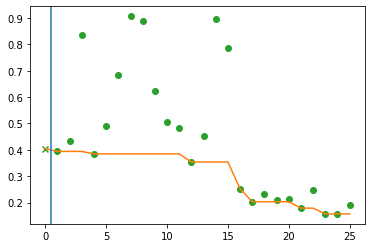

In [58]:
import numpy as np
import tensorflow as tf

from trieste.acquisition import AcquisitionFunction
from trieste.types import TensorType
from trieste.utils import to_numpy
from trieste.acquisition.multi_objective.dominance import non_dominated



fig, ax = plt.subplots(1, 1, sharey="all")
plotting.plot_regret(
    data[OBJECTIVE].observations.numpy(),
    ax,
    num_init=len(initial_data[OBJECTIVE])
)

